## Simple Image Classification problem

We're going to use a convolutional neural networks (CNN) to allow our computer to distinguish two different kinds of pictures.

Many thanks to fast.ai (based on https://github.com/fastai/fastai/blob/master/courses/dl1/lesson1.ipynb)

## Classifying 'Dogs vs Cats'

We're going to try to create a model to enter the [Dogs vs Cats competition at Kaggle](https://www.kaggle.com/c/dogs-vs-cats). There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): "State of the art: The current literature suggests machine classifiers can score above 80% accuracy on this task". So if we can beat 80%, then we will be at the cutting edge as of 2013!

In [8]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Here we import the libraries we need. We'll learn about what each does later on.

In [1]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [2]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

`PATH` is the path to your data—if you use the recommended setup approaches from the lesson, you won't need to change this. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at `224` for now.

In [3]:
arch=resnet34
PATH = "../../data/dogscats/"
sz=224

### Extra steps if NOT using Clouderizer

The dataset is available at http://files.fast.ai/data/dogscats.zip. You can download it directly on your server by running the following line in your terminal. 
```
wget http://files.fast.ai/data/dogscats.zip

```
 You should put the data in a subdirectory of the parent of this notebook's directory, called `../data/`. Note that this data is already available when running from the Clouderizer .

## First look at test1 directory

Our library will assume that you have *train*, *valid*, and *test1* directories. It also assumes that the *train* and *valid* directories will have subdirs for each class you wish to recognize (in this case, 'cats' and 'dogs').

The *test1* directory will contain a set of test images whose filename starts with an ID.

In [4]:
os.listdir(PATH)

['tmp', 'test1', 'train', 'valid', 'sample', 'models']

In [5]:
files = os.listdir(f'{PATH}test1')[:5]
files

['2564.jpg', '8243.jpg', '2039.jpg', '12023.jpg', '6212.jpg']

## Our first model: quick start

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks). We'll be studying them in depth later, but for now we'll focus on using them effectively.

Here's how to train and evalulate a *dogs vs cats* model in 3 lines of code, and under 20 seconds:

In [6]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [7]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz),
                                      test_name="test1")


In [8]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /content/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:06<00:00, 14533760.61it/s]


100%|██████████| 196/196 [00:29<00:00,  6.68it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.042953   0.02627    0.9915    
    1      0.039007   0.02702    0.9915    



[array([0.02702]), 0.9915]

## Creating predictions for test data and writing CSV


We see that by providing the *test_name* parameter to our dataset, we've now got a *test_ds* field in ou
model data.

In [41]:
data.test_ds.fnames[:10]

['test1/12470.jpg',
 'test1/12387.jpg',
 'test1/2227.jpg',
 'test1/3479.jpg',
 'test1/8584.jpg',
 'test1/2111.jpg',
 'test1/5706.jpg',
 'test1/8959.jpg',
 'test1/8583.jpg',
 'test1/8223.jpg']

Let's make predictions for that test data.  Remember that we're given log probabilities which we must 
exponentiate in order to yield true probabilities.

In [83]:
log_preds, y = learn.predict_with_targs(is_test=True) # use test dataset rather than validation dataset
probs = np.exp(log_preds)

We're given probabilities for both the cat and the dog classes for each of the 12,500 test images. 

In [49]:
probs.shape # (n_images, n_classes)

(12500, 2)

We see the classes for the dataset (we see that 'cats' is 0 and 'dogs' is 1):

In [51]:
data.classes

['cats', 'dogs']

We see the probabilities for the dogs (extracting out the dog column).

In [59]:
probs[:,1:]

array([[0.     ],
       [0.99986],
       [0.00011],
       ...,
       [0.99999],
       [0.97629],
       [0.99993]], dtype=float32)

We create a Pandas DataFrame from the dog probabilities. We name the column 'label' (as specified by the Kaggle submission guidelines).

In [84]:
df = pd.DataFrame(probs[:,1:])
df.columns = ['label']

We want a new first column named *id* that has the ID extracted from each test image's filename.

In [85]:
df.insert(0, 'id', [o[6:-4] for o in data.test_ds.fnames])

In [57]:
df.head()

,id,label
0,2564,0.000001
1,8243,0.999858
2,2039,0.000107
3,12023,0.999766
4,6212,0.000040


We write into the *out* directory the dogscats_simple.zip CSV file.

In [86]:
SUBM = f'../../out/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}dogscats_simple2.gz', compression='gzip', index=False)

At this point, there should now be a dogscats_simple.gz file in the *out* directory.

You can either:
* Download from Jupyter: Use the left sidebar (*View/Show Left Sidebar* if the sidebar isn't showing) to navigate to the out directory.  Right-click on ```dogscats.gz``` to download it to your computer.  
* Download from Google Drive (in the Clouderizer folder). 
    
Once you've got the file on your local machine, you can upload it to kaggle.

When I uploaded this CSV to Kaggle, this solution would have placed me at 118th place on the public leaderboard (out of 1300 submissions).

## Choosing a learning rate

The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affects model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.

In [23]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [24]:
lrf=learn.lr_find()

 82%|████████▏ | 294/360 [00:01<00:00, 167.73it/s, loss=0.21] 


Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

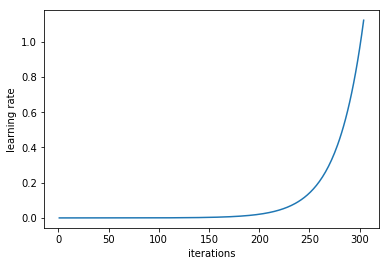

In [8]:
learn.sched.plot_lr()

Note that in the previous plot *iteration* is one iteration (or *minibatch*) of SGD. In one epoch there are 
(num_train_samples/num_iterations) of SGD.

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

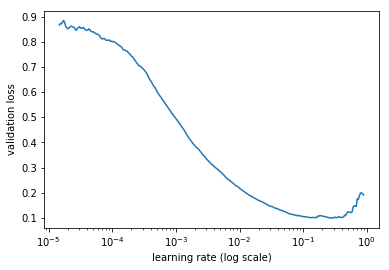

In [9]:
learn.sched.plot()

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use. Note that the optimal learning rate can change as we train the model, so you may want to re-run this function from time to time.

So, now you can see where the learning rate of 0.01 came from in the call to ```learn.fit``` above.

## Improving our model

### Data augmentation

If you try training for more epochs, you'll notice that we start to *overfit*, which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through *data augmentation*. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing `aug_tfms` (*augmentation transforms*) to `tfms_from_model`, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions `transforms_side_on`. We can also specify random zooming of images up to specified scale by adding the `max_zoom` parameter.

In [12]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [13]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [14]:
ims = np.stack([get_augs() for i in range(6)])

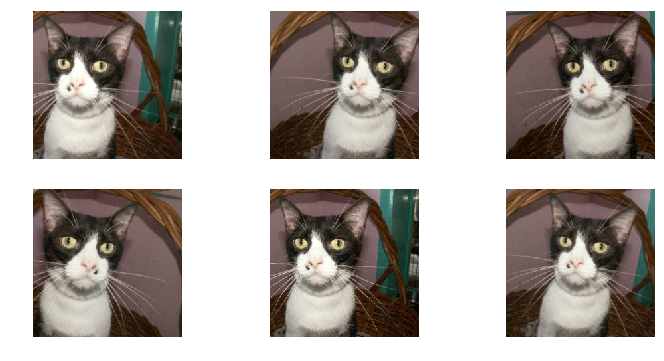

In [15]:
plots(ims, rows=2)

Let's create a new `data` object that includes this augmentation in the transforms.

Since we're using data augmentation, we can't use the speedup of precomputing the activations of the network up to, but not including, the final layer for each image.  Instead, we must feed each (augmented) image to the network. Thus, we don't provide a ```precompute``` parameter to the ```pretrained``` method.

In [16]:
data = ImageClassifierData.from_paths(PATH, test_name="test1", tfms=tfms)
learn = ConvLearner.pretrained(arch, data)

By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [17]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.069851   0.034162   0.9875    
    1      0.052834   0.029169   0.99      
    2      0.056426   0.030068   0.99      



[array([0.03007]), 0.99]

What is that `cycle_len` parameter? What we've done here is used a technique called *stochastic gradient descent with restarts (SGDR)*, a variant of *learning rate annealing*, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"):

<img src="images/sgdr.png" width="80%">
(From the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

The number of epochs between resetting the learning rate is set by `cycle_len`, and the number of times this happens is refered to as the *number of cycles*, and is what we're actually passing as the 2nd parameter to `fit()`. So here's what our actual learning rates looked like:

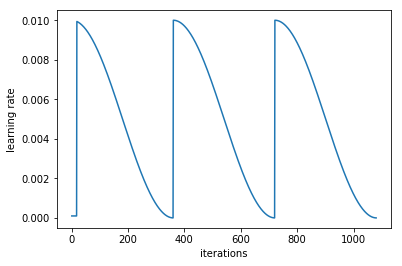

In [17]:
learn.sched.plot_lr()

Our validation loss isn't improving much, so there's probably no point further training the last layer on its own.

Since we've got a pretty good model at this point, we might want to save it so we can load it again later without training it from scratch.

In [ ]:
learn.save('dogscats_lastlayer')

In [ ]:
learn.load('dogscats_lastlayer')

In [ ]:
We can look at the accuracy for 

In [68]:
log_preds, y = learn.predict_with_targs() # use test dataset rather than validation dataset
probs = np.exp(log_preds)
accuracy_np(probs, y)

0.9905

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). To use TTA on the validation set, we can use the learner's `TTA()` method, and then take the average prediction from these images. 

In [69]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y)

0.992

This gives a slight enhancement to the accuracy. We can save this model for later use:

In [ ]:
learn.save('dogscats_augmentation')
learn.load('dogscats_augmentation')

Let's try another Kaggle submission using our model so far (and using test-time augmentation).

In [71]:
log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds), 0)
df = pd.DataFrame(probs[:,1:])
df.columns = ['label']
df.insert(0, 'id', [o[6:-4] for o in data.test_ds.fnames])
SUBM = f'../../out/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}dogscats_augmentation.gz', compression='gzip', index=False)

We write into the *out* directory the dogscats_augmentation.zip CSV file. 

## Fine-tuning the model

By default, when we create a *pretrained* model, it freezes the weights of all but the last layer.  What we can do is take the model that we have so far (which has learned the weights of the last layer), unfreeze all the layers, and then do some more training.  This gives an opportunity to fine-tune the existing weights.|

In [18]:
learn.unfreeze()

The earlier layers are in less of need of training since they've learned very low-level features. 
We'll go ahead and set three different learning rates: for the early layers, the middle layers, and the last layers:

In [19]:
lr=np.array([1e-4,1e-3,1e-2])


In [20]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.055698   0.026622   0.9905    
    1      0.048376   0.023668   0.991     
    2      0.029027   0.020728   0.9935    
    3      0.030522   0.024045   0.99      
    4      0.027219   0.020492   0.9925    
    5      0.032148   0.020584   0.991     
    6      0.022322   0.020043   0.9925    



[array([0.02004]), 0.9925]

We can save this model as well:

In [75]:
learn.save('dogscats_alllayers')
learn.load('dogscats_alllayers')

Let's try another Kaggle submission using our model so far (and using test-time augmentation).

In [78]:
log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds), 0)
df = pd.DataFrame(probs[:,1:])
df.columns = ['label']
df.insert(0, 'id', [o[6:-4] for o in data.test_ds.fnames])
SUBM = f'../../out/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}dogscats_alllayers.gz', compression='gzip', index=False)

114th in public leaderboard